In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [2]:
train_data = datasets.FashionMNIST(root = "data",
                                   train = True,
                                   download = True,
                                   transform = ToTensor(),
                                   target_transform = None)
test_data = datasets.FashionMNIST(root = "data",
                                  train = False,
                                  download = True,
                                  transform = ToTensor(),
                                  target_transform = None)

Text(0.5, 1.0, '9')

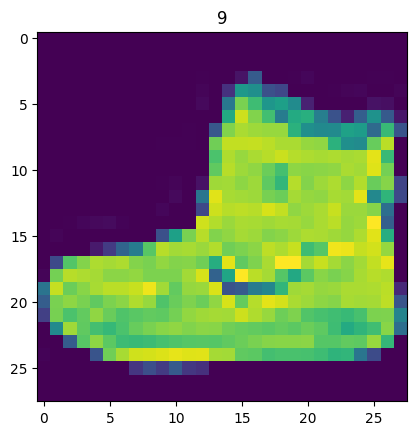

In [3]:
import matplotlib.pyplot as plt
image, label = train_data[0]
plt.imshow(image.squeeze())
plt.title(label)

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

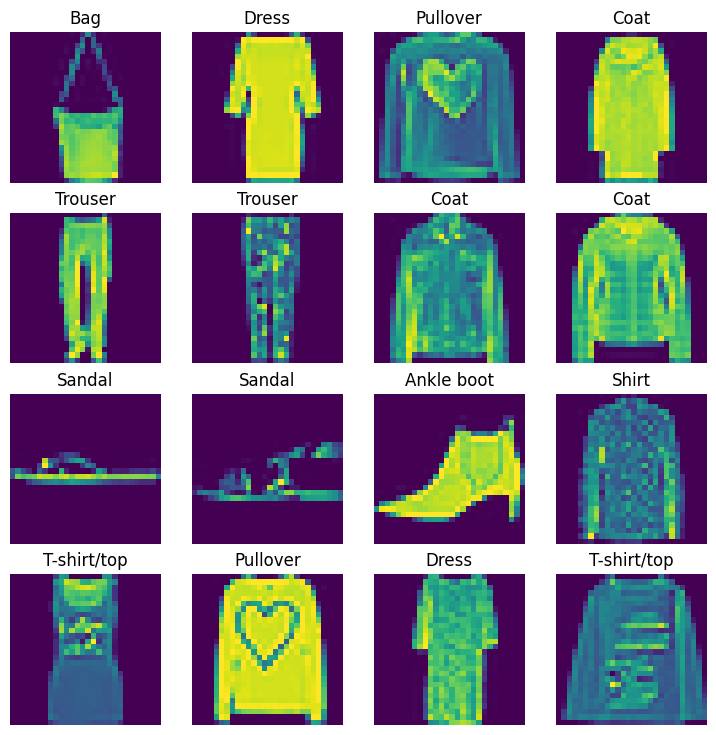

In [9]:
fig = plt.figure(figsize = (9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size = (1,)).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze())
    plt.title(class_names[label])
    plt.axis(False)

In [12]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Turn datasets into iterables / batches
train_dataloader = DataLoader(train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)
test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

In [15]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [17]:
# Test out flatten layer
flatten_model = nn.Flatten()
x = train_features_batch[0]
print(x.shape)
output = flatten_model(x) # [color_channels, height*width]
print(output.shape)

torch.Size([1, 28, 28])
torch.Size([1, 784])


In [19]:
tens = torch.randn([2,3,4,5])
print(flatten_model(tens).shape)

torch.Size([2, 60])


In [20]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    def forward(self, x):
        return self.layer_stack(x)

In [21]:
model_0 = FashionMNISTModelV0(input_shape=28*28,
                              hidden_units=10,
                              output_shape=len(class_names))

In [22]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


helper_functions.py already exists, skipping download


In [23]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [24]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
from tqdm.auto import tqdm

train_time_start_on_cpu = timer()

epochs = 3

# Training
for epoch in tqdm(range(epochs)):
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"At batch: {batch} out of a total of {len(train_dataloader)} batches")
    loss /= len(train_dataloader)

    # Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader: